**ARIMA** (AutoRegressive Integrated Moving Average):
- Components: ARIMA models consist of three main components: Autoregressive (AR) terms, Integrated (I) terms, and Moving Average (MA) terms.
- Manual Selection: In a traditional ARIMA approach, you manually select the order of the AR, I, and MA components based on analysis of the autocorrelation and partial autocorrelation plots, as well as stationarity tests.
- Usage: ARIMA is a powerful and flexible method, but choosing the right orders can be challenging, especially for users without extensive time series expertise.
Auto-ARIMA:

**Automated Parameter Selection**: Auto-ARIMA, on the other hand, automates the process of selecting the order of the ARIMA model.
- Search Algorithm: Auto-ARIMA typically employs a search algorithm that explores different combinations of AR, I, and MA orders to find the model with the lowest Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
- Ease of Use: Auto-ARIMA is user-friendly and requires less manual intervention compared to traditional ARIMA. It is suitable for users who are less familiar with time series analysis.

# ARIMA

ARIMA(p,d,q) 
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

- AR term refers to the past values used for forecasting the next value. The AR term is defined by the parameter ‘p’ in arima. The value of ‘p’ is determined using the PACF plot.

- MA term is used to defines number of past forecast errors used to predict the future values. The parameter ‘q’ in arima represents the MA term. ACF plot is used to identify the correct ‘q’ value.

- Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary. Test like ADF and KPSS can be used to determine whether the series is stationary and help in identifying the d value.

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [2]:
# import data
df = pd.read_csv('df_post_eda.csv')

In [3]:
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
df = pd.DataFrame(df)
df.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


In [4]:
# Scale data -> some % columns, some raw number columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head(3)

,Additional_Doses_Vax_Pct
Date,
2021-11-03,0.000000
2021-11-10,0.070026
2021-11-17,0.135949


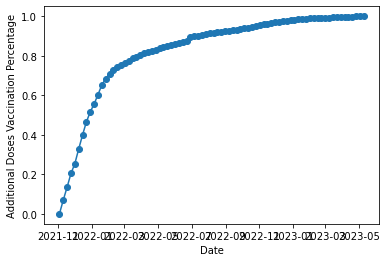

In [5]:
plt.plot(df_scaled.index, df_scaled['Additional_Doses_Vax_Pct'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Additional Doses Vaccination Percentage')
plt.show()

### Stationary Test

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [6]:
# Time series are stationary if they do not have trend or seasonal effects. 
#Summary statistics calculated on the time series are consistent over time, 
# like the mean or the variance of the observations.

from statsmodels.tsa.stattools import adfuller

X = df_scaled.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.009253
p-value: 0.001363
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587


##### p-value < 0.05 so we Reject the Null Hypothesis, the data is stationary

### Autocorrelation Test

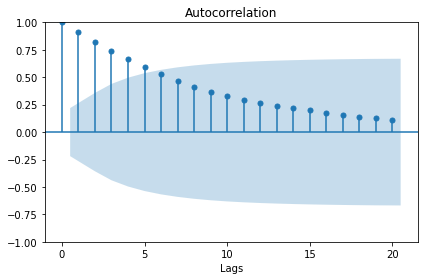

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
alpha=0.05
# Select a multiple of the seasonal frequency for the number of lags
plot_acf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


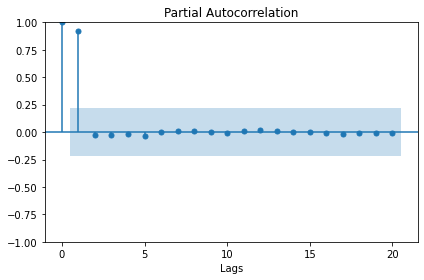

In [8]:
plot_pacf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

### Base ARIMA Model

In [9]:
# Splitting data into Train and Test -> test is from start of 2023 and beyond

split_date = '2023-01-03'

train = df_scaled[df_scaled.index < split_date]
test = df_scaled[df_scaled.index >= split_date]

print(train.shape, test.shape) # 70-30 train split

(61, 1) (19, 1)


In [10]:
# Fit an ARIMA model on the training data
order = (1, 0, 0)  # Initial, Lag=1
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.06979395693648954
Testing RMSE: 0.02244345802383273


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)


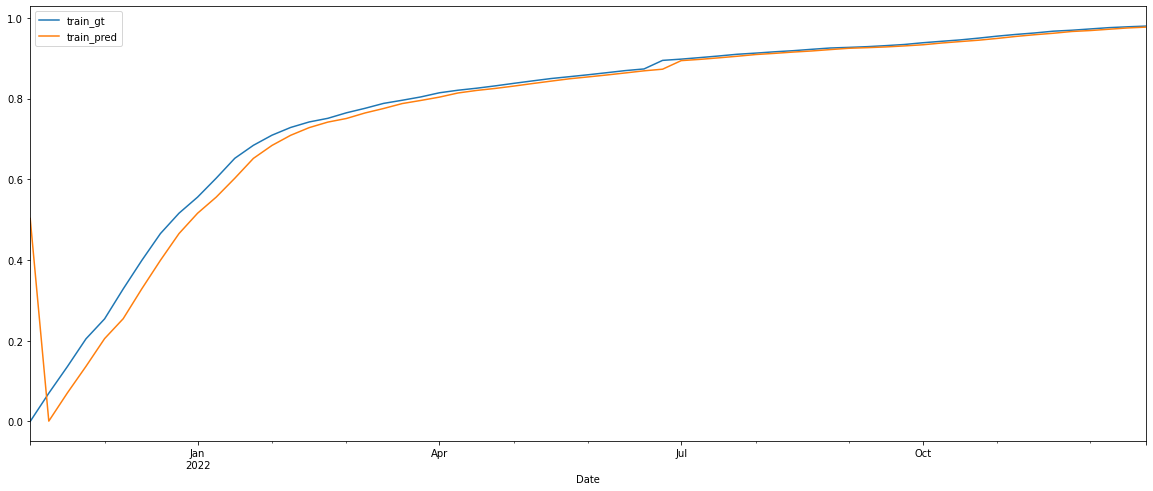

In [11]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

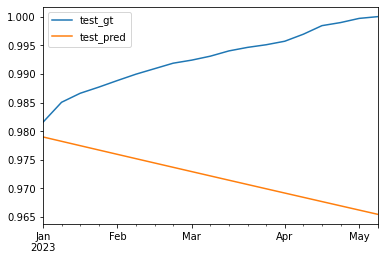

In [12]:
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

### Tuning ARIMA Model

1. Split the dataset into training and test sets.
2. Walk the time steps in the test dataset.
    1. Train an ARIMA model.
    2. Make a one-step prediction.
    3. Store prediction; get and store actual observation.
3. Calculate error score for predictions compared to expected values.

In [14]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7625)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])  
    # calculate out of sample error
    error = np.sqrt(mean_squared_error(test, predictions))
    return error

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.10f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.10f' % (best_cfg, best_score))

In [19]:
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(df_scaled.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.1926951832
ARIMA(0, 0, 1) RMSE=0.0996517749
ARIMA(0, 0, 2) RMSE=0.0554941849
ARIMA(0, 0, 3) RMSE=0.0314626435
ARIMA(0, 0, 4) RMSE=0.0246506295
ARIMA(0, 1, 0) RMSE=0.0012708135
ARIMA(0, 1, 1) RMSE=0.0008911830
ARIMA(0, 1, 2) RMSE=0.0008083023
ARIMA(0, 1, 3) RMSE=0.0012867564
ARIMA(0, 1, 4) RMSE=0.0009530074
ARIMA(0, 2, 0) RMSE=0.0006798906
ARIMA(0, 2, 1) RMSE=0.0006387421
ARIMA(0, 2, 2) RMSE=0.0006449264
ARIMA(0, 2, 3) RMSE=0.0006423944
ARIMA(0, 2, 4) RMSE=0.0009028929
ARIMA(0, 3, 0) RMSE=0.0010933485
ARIMA(0, 3, 1) RMSE=0.0008486130
ARIMA(0, 3, 2) RMSE=0.0007104665
ARIMA(0, 3, 3) RMSE=0.0006684728
ARIMA(0, 3, 4) RMSE=0.0006954747
ARIMA(0, 4, 0) RMSE=0.0018985664
ARIMA(0, 4, 1) RMSE=0.0011640403
ARIMA(0, 4, 2) RMSE=0.0009625071
ARIMA(0, 4, 3) RMSE=0.0007860906
ARIMA(0, 4, 4) RMSE=0.0007297925
ARIMA(1, 0, 0) RMSE=0.0018709147
ARIMA(1, 0, 1) RMSE=0.0056748802
ARIMA(1, 0, 2) RMSE=0.0041813415
ARIMA(1, 0, 3) RMSE=0.0019208955
ARIMA(1, 0, 4) RMSE=0.0013682472
ARIMA(1, 1

In [28]:
def get_rmses(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7625)
    train, test = X[0:train_size], X[train_size:]
    
    # make predictions for the training set
    train_history = [x for x in train]
    train_predictions = list()
    
    for t in range(len(train)):
        model = ARIMA(train_history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        train_predictions.append(yhat)
        train_history.append(train[t])
    
    # make predictions for the test set
    test_history = [x for x in train]
    test_predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(test_history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        test_predictions.append(yhat)
        test_history.append(test[t])  
    
    # calculate in-sample error (train RMSE)
    train_error = np.sqrt(mean_squared_error(train, train_predictions))
    
    # calculate out-of-sample error (test RMSE)
    test_error = np.sqrt(mean_squared_error(test, test_predictions))
    
    return train_error, test_error, train_predictions, test_predictions

In [43]:
train_rmse, test_rmse, train_predictions, test_predictions = get_rmses(df_scaled.values, (4, 1, 3))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 0.17108833119439146
Test RMSE: 0.0005706037271976515


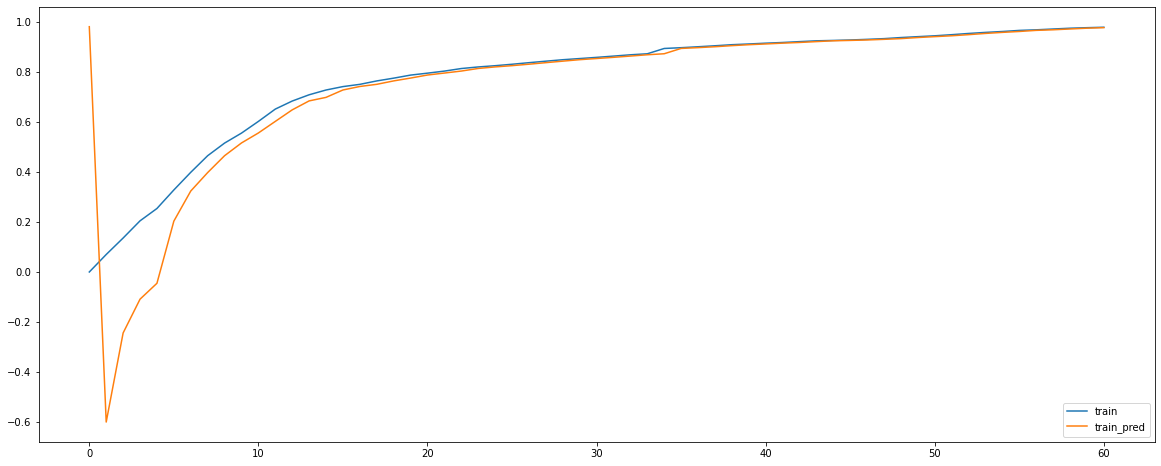

In [68]:
pd.concat([train.reset_index()['Additional_Doses_Vax_Pct'], pd.DataFrame(train_predictions)], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

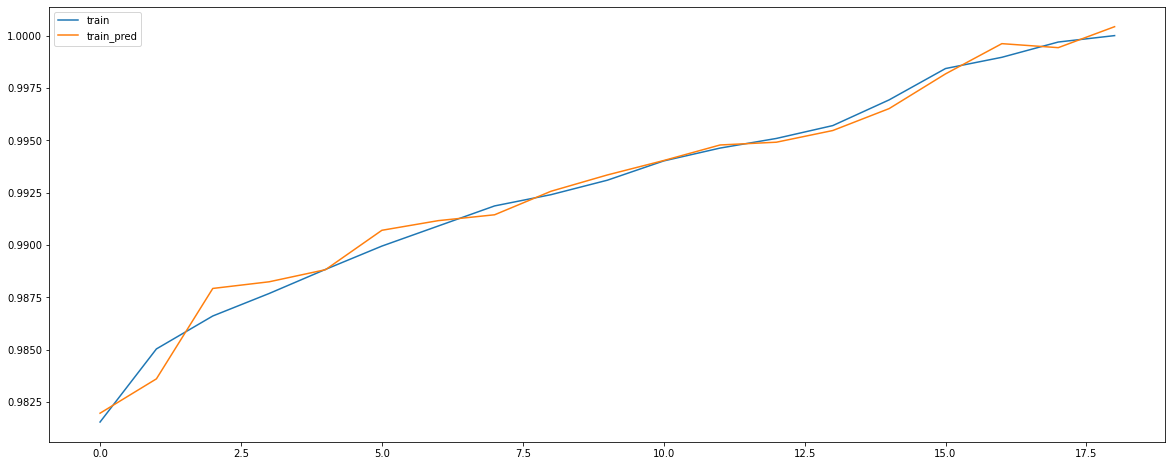

In [69]:
pd.concat([test.reset_index()['Additional_Doses_Vax_Pct'], pd.DataFrame(test_predictions)], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

In [39]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and testing sets
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Define the range of hyperparameters for the grid search
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)  # Adjust the number of splits as needed
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (4, 2, 4)
Lowest Average Test RMSE: 0.008177070120104355


In [43]:
# the RMSE seems to be fitting the test data a lot better than the train data, why is it
# Fit an ARIMA model on the training data
order = (4, 2, 4)  # Initial, Lag=1
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.010855415562449896
Testing RMSE: 0.0015318284264584099


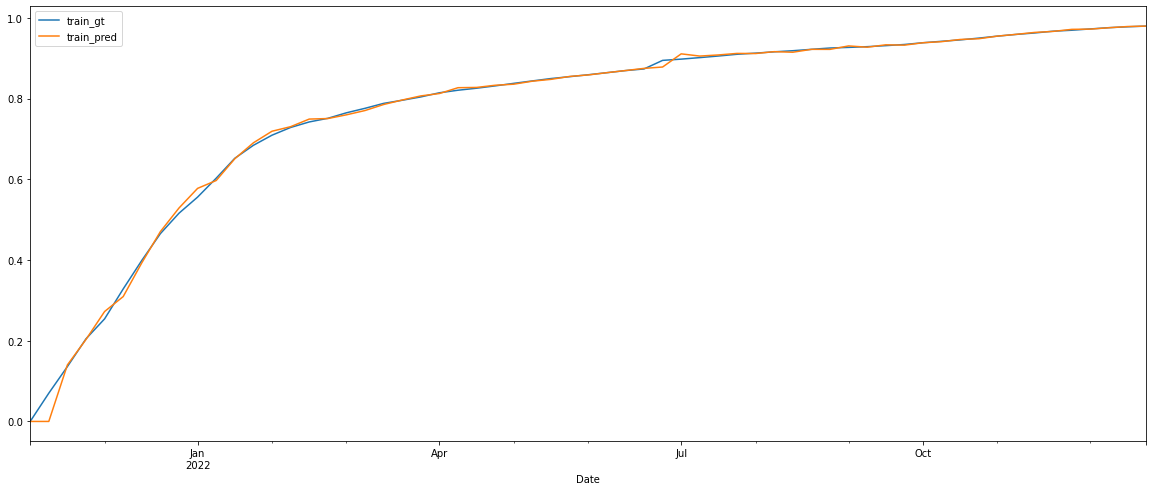

In [44]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

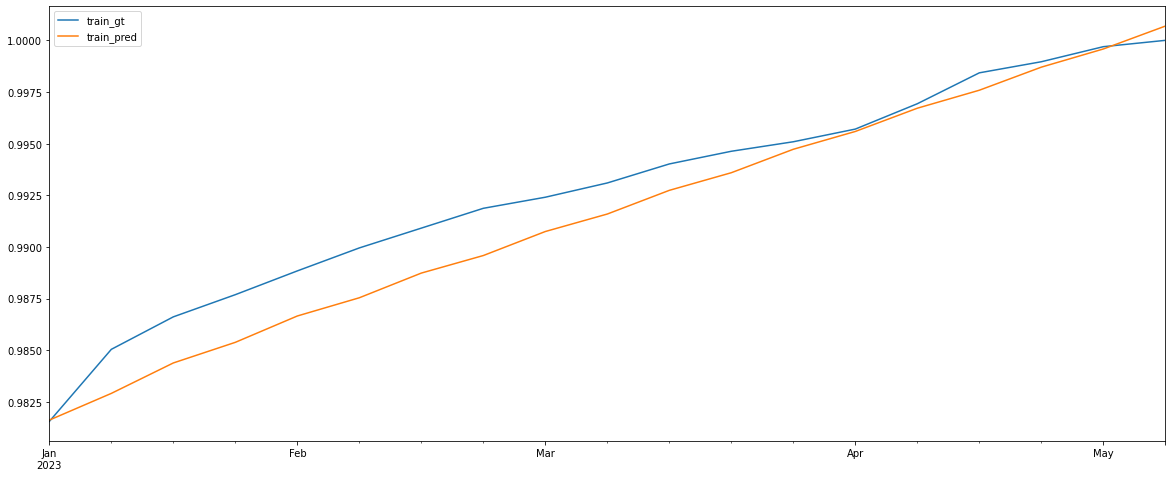

In [41]:
pd.concat([test, test_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

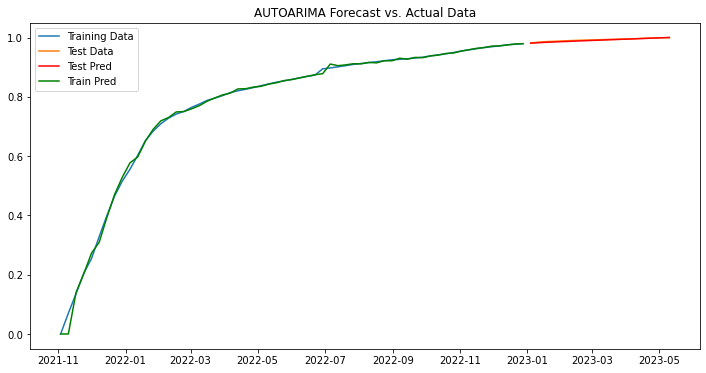

In [45]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

# Auto-ARIMA

In [16]:
from pmdarima.arima import auto_arima

In [55]:
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[0:train_size], df_scaled[train_size:]
#print(train.shape, test.shape)
#using the scaled data is making the AIC negative

#### Baseline Auto-ARIMA model

In [56]:
model = auto_arima(train, seasonal=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-417.849, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-422.034, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-423.808, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-423.754, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-421.822, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-421.799, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-419.834, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-424.874, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-421.845, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-423.152, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-423.335, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-425.399, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-423.399, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-413.370, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 0, 2, 1
P, D, Q, S = 0, 0, 0, 0

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.506200
         Iterations: 2
         Function evaluations: 88
Training RMSE: 0.0109807075283679
Testing RMSE: 0.00829762933624131


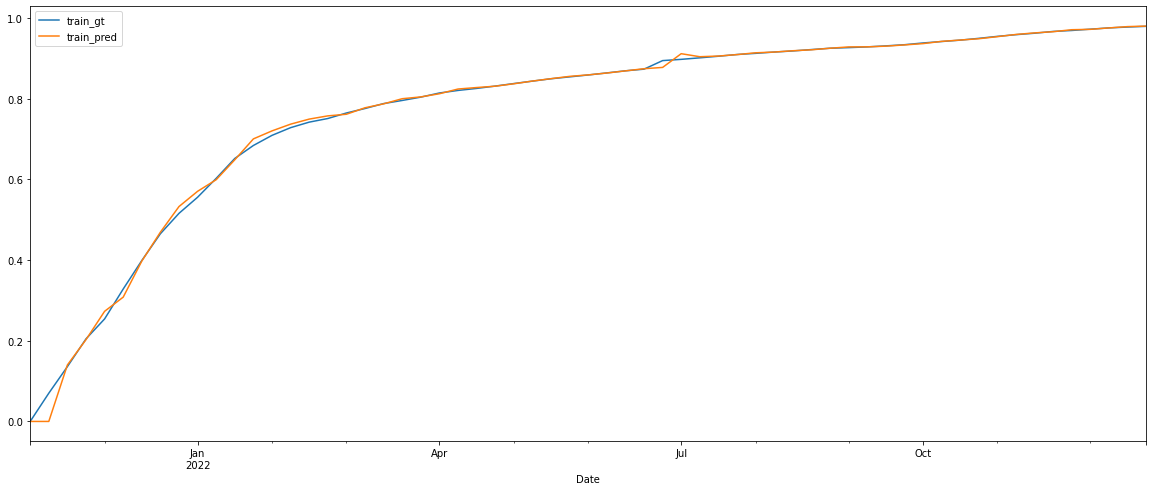

In [67]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

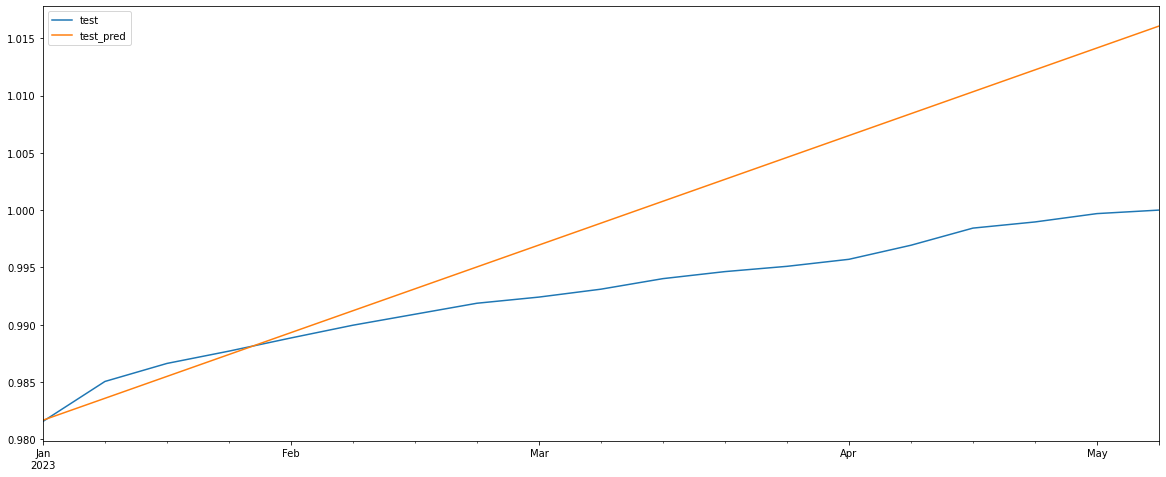

In [70]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

### Tuning SARIMAX Model

In [64]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
S_values = [12] 

In [65]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming 'train' and 'test' are your time series training and testing sets

best_test_rmse = float('inf')
best_params = None

for p, d, q, P, D, Q, S in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
    fit_model = model.fit(disp=False)

    # Make predictions on the test set
    test_pred = fit_model.get_forecast(steps=len(test)).predicted_mean

    # Calculate RMSE for the test set
    test_rmse = sqrt(mean_squared_error(test, test_pred))

    # Update best parameters if current combination has lower test RMSE
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        best_params = (p, d, q, P, D, Q, S)

print(f"Best SARIMAX Parameters: {best_params}")
print(f"Lowest Test RMSE: {best_test_rmse}")

Best SARIMAX Parameters: (2, 1, 1, 0, 0, 2, 12)
Lowest Test RMSE: 0.0010052369133782078


In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 2, 1, 1
P, D, Q, S = 0, 0, 2, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.557890
         Iterations: 4
         Function evaluations: 377
Training RMSE: 0.010938884668406224
Testing RMSE: 0.0018469419277994954


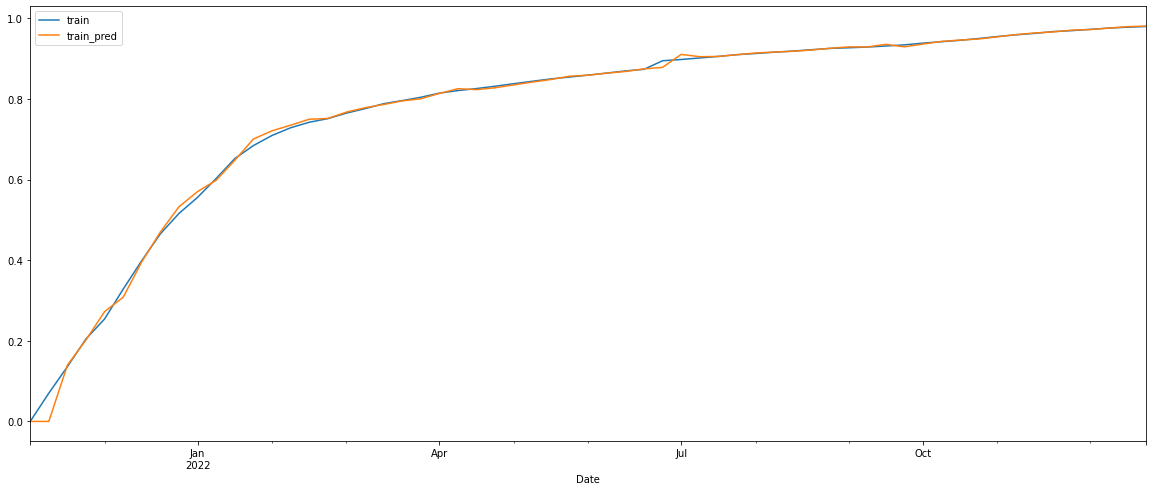

In [72]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

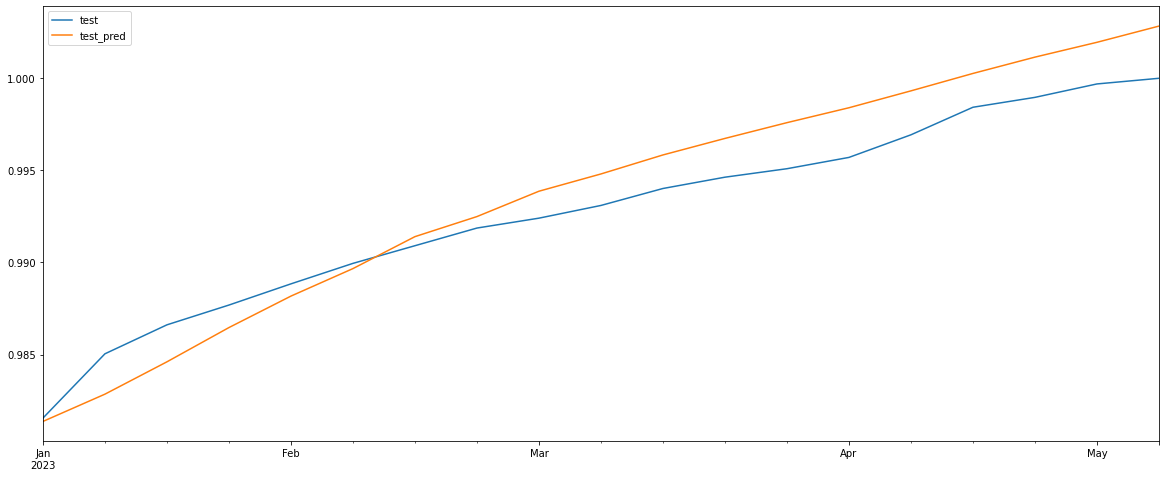

In [73]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

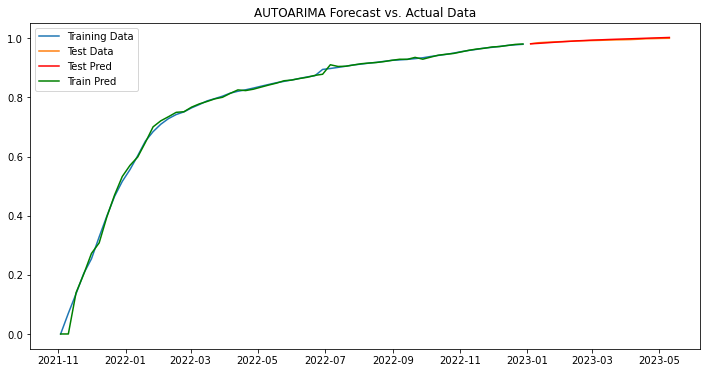

In [74]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred_mean, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()